## Predviđanje vrednosti bitkoina za DAYS_TO_PREDICT_SVR dana korišćenjem SVR

**Korišćeni atributi:** Close

**Napomena:** Podaci koji predstavljaju vrednosti bitkoina su dati u minutima.

**Filtrirani podaci:** od 38.03.2021.

**Koraci:**
1. Učitavanje i pretprocesiranje podataka
2. Filtriranje kolona
3. Odredjivanje ciljne promenljive za svaki od skupova
4. Podela skupa podataka i skaliranje
5. Kreiranje i treniranje modela i računanje skora
6. Izracunavanje metrika
7. Predvidjanje poslednjih DAYS_TO_PREDICT_SVR dana

### Učitavanje biblioteka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle

%run 02_Preprocessing_and_data_analysis.ipynb
#%run 03_Utility_functions.ipynb

In [5]:
DAYS_TO_PREDICT_SVR = 60

### Učitavanje i pretprocesiranje skupa podataka

In [6]:
data = preprocess_data(file_name = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [7]:
data = filter_data(data, date_str = '2021-03-28')

In [8]:
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4854496,1616976000,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695,2021-03-29
4854497,1616976060,55822.98,55857.28,55822.98,55857.28,0.589603,32931.781301,55854.182542,2021-03-29
4854498,1616976120,55822.98,55829.04,55766.15,55779.04,2.729659,152263.034630,55780.964698,2021-03-29
4854500,1616976240,55766.15,55768.63,55766.15,55768.63,0.023738,1323.776861,55766.455065,2021-03-29
4854501,1616976300,55770.46,55778.48,55736.83,55742.20,0.389067,21692.454676,55755.006032,2021-03-29
...,...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339,2021-03-30
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508,2021-03-30
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496,2021-03-30
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202,2021-03-30


### Uklanjanje nepotrebnih kolona

In [9]:
data = data.drop(['Timestamp', 'Open', 'High', 'Low', 'Volume_(BTC)','Volume_(Currency)','Weighted_Price', 'Date'], axis=1)
data.head()

,Close
4854496,55804.36
4854497,55857.28
4854498,55779.04
4854500,55768.63
4854501,55742.20


### Vizuelni prikaz podataka

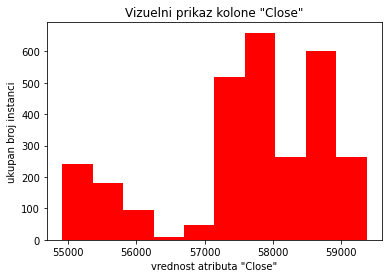

In [10]:
plt.title('Vizuelni prikaz kolone "Close"')
plt.hist(data['Close'],color='red')
plt.xlabel('vrednost atributa "Close"')
plt.ylabel('ukupan broj instanci')
plt.show()

Sa grafika se moze zakljuciti da najvise ima onih instanci cija je vrednost atributa 'Close' u intervalu [57000, 58000] i u intervalu [58500, 59000] (grubo).

### **Odredjivanje ciljne promenljive**

In [11]:
# Funkcija koja odredjuje skupove X i y (y je target promenljiva)
# na osnovu datog skupa podataka i dana za predvidjanje, tako sto
# kreira novu kolonu 'Predictions' u koju upisuje predvidjene vrednosti

def determine_x_and_y(days_to_predict, data):
    
    data['Predictions'] = data[['Close']].shift(-days_to_predict)
    
    last_instance = len(data) - days_to_predict

    X = data.drop(['Predictions'], 1)
    X = np.array(X)
    X = X[: last_instance]

    y = data['Predictions']
    y = np.array(y)
    y = y[: last_instance]
    
    
    # Vizuelni prikaz X i y
    
    plt.title('Vrednosti atributa X i ciljne promenljive y')
    plt.plot(y, label = 'y', color = 'red')
    plt.plot(X, label = 'X', color = 'darkorange')
    #plt.xlabel('Timestamp')
    plt.ylabel('Vrednost atributa "Close"')
    plt.legend(loc = 'best')
    plt.show()
    
    return X, y

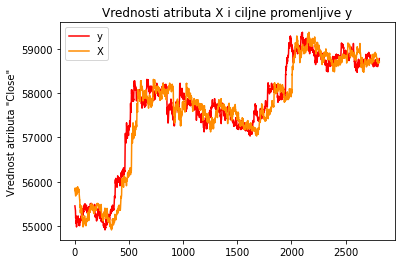

In [12]:
X, y = determine_x_and_y(DAYS_TO_PREDICT_SVR, data)

U narednim linijama koda (naredne dve linije) se može videti da ciljna promenljiva $y$ ima vrednosti koje se kreću od vrednosti 60. elementa atributa $X$.

In [13]:
X[59:]

array([[55455.06],
       [55457.06],
       [55439.84],
       ...,
       [58703.26],
       [58706.76],
       [58705.95]])

In [14]:
y

array([55457.06, 55439.84, 55415.07, ..., 58723.84, 58760.59, 58778.18])

### **Podela skupa podataka i skaliranje**

In [40]:
# Funkcija koja vrsi podelu skupa podataka
# na skupove za treniranje i testiranje

def split_data(days, X, y, test_size):
    
    limit = len(X) - test_size
    X_train = X[: limit]
    y_train = y[: limit]
    X_test = X[limit :]
    y_test = y[limit :]
    
    
    # Skaliranje
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Vizuelni prikaz
        
    #plt.title('Train i test skup')
    #plt.plot(X_train, label = 'X train')
    #plt.plot(X_test, label = 'X test')
    #plt.plot(y_train, label = 'y train')
    #plt.plot(y_test, label = 'y test')
    #plt.ylabel('Vrednost atributa "Close"')
    #plt.legend(loc = 'best')
    #plt.show()
    
    return X_train, X_test, y_train, y_test

### Kreiranje i treniranje modela i računanje skora

In [41]:
# Funkcija koja kreira model, trenira ga
# i izracunava skor (r2 skor) modela

def calculate_score(days, X, y, test_size = 100):
    
    X_train, X_test, y_train, y_test = split_data(days, X, y, test_size)
    
    # kreiranje Support Vector Machine (SVM) modela koristeci radial basis funkciju - rbf
    svr_rbf = SVR(kernel = 'rbf', gamma = 0.00001)
    
    # kreiranje Support Vector Machine (SVM) modela koristeci poly funkciju
    svr_poly = SVR(kernel='poly', epsilon=.2, coef0=1)
    
    # kreiranje Support Vector Machine (SVM) modela koristeci sigmoid funkciju
    svr_sigmoid = SVR(kernel='sigmoid', C = 0.1, epsilon=.2)
    
    # kreiranje Support Vector Machine (SVM) modela koristeci linear funkciju
    svr_linear = SVR(kernel='linear', C = 0.1, epsilon=.2)

    # treniranje modela
    svr_rbf.fit(X_train, y_train)
    svr_poly.fit(X_train, y_train)
    svr_sigmoid.fit(X_train, y_train)
    svr_linear.fit(X_train, y_train)
    
    # racunanje r2 skora modela
    svr_rbf_score = svr_rbf.score(X_test, y_test)
    svr_poly_score = svr_poly.score(X_test, y_test)
    svr_sigmoid_score = svr_sigmoid.score(X_test, y_test)
    svr_linear_score = svr_linear.score(X_test, y_test)
    
    models = [svr_rbf, svr_poly, svr_sigmoid, svr_linear]
    scores = [svr_rbf_score, svr_poly_score, svr_sigmoid_score, svr_linear_score]
    
    return models, scores, X_test, y_test

In [17]:
data.head()

,Close,Predictions
4854496,55804.36,55457.06
4854497,55857.28,55439.84
4854498,55779.04,55415.07
4854500,55768.63,55414.25
4854501,55742.20,55386.82


In [42]:
# Izvrsavanje funkcije

models, scores, X_test, y_test = calculate_score(days = DAYS_TO_PREDICT_SVR, X = X, y = y, test_size = 100)

In [19]:
# X_test[:5]

In [20]:
# Skorovi

svr_rbf_score = scores[0]
svr_poly_score = scores[1]
svr_sigmoid_score = scores[2]
svr_linear_score = scores[3]

In [21]:
# Modeli

svr_rbf = models[0]
svr_poly = models[1]
svr_sigmoid = models[2]
svr_linear = models[3]

In [22]:
# Drugi nacin za racunanje skora

r2_score(y_test, svr_rbf.predict(X_test)), r2_score(y_test, svr_poly.predict(X_test)), r2_score(y_test, svr_sigmoid.predict(X_test)), r2_score(y_test, svr_linear.predict(X_test))

(-140.53664902683028,
 -1.549573516069544,
 -142.10822814735718,
 -137.65154684940134)

### Vizuelni prikazi predvidjanja SVRa sa različitim kernelima

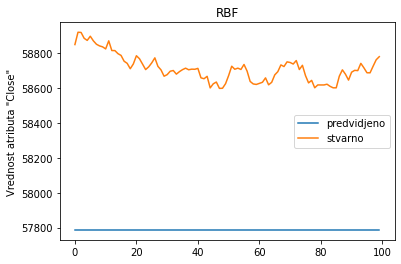

In [23]:
# RBF

svr_rbf_pred = svr_rbf.predict(X_test)
plt.title('RBF')
plt.ylabel('Vrednost atributa "Close"')
plt.plot(svr_rbf_pred, label='predvidjeno')
plt.plot(y_test, label = 'stvarno')
plt.legend()
plt.show()

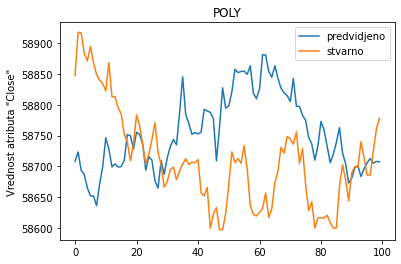

In [24]:
# POLY

svr_poly_pred = svr_poly.predict(X_test)
plt.title('POLY')
plt.ylabel('Vrednost atributa "Close"')
plt.plot(svr_poly_pred, label = 'predvidjeno')
plt.plot(y_test, label = 'stvarno')
plt.legend()
plt.show()

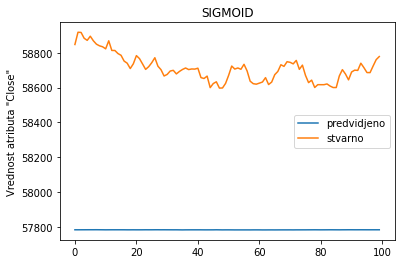

In [25]:
# SIGMOID

svr_sigmoid_pred = svr_sigmoid.predict(X_test)
plt.title('SIGMOID')
plt.ylabel('Vrednost atributa "Close"')
plt.plot(svr_sigmoid_pred, label = 'predvidjeno')
plt.plot(y_test, label = 'stvarno')
plt.legend()
plt.show()

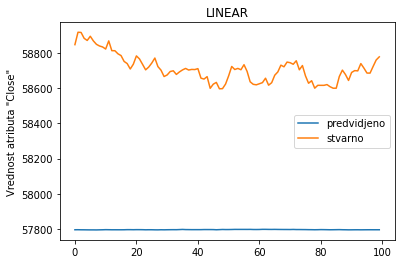

In [26]:
# LINEAR

svr_linear_pred = svr_linear.predict(X_test)
plt.title('LINEAR')
plt.ylabel('Vrednost atributa "Close"')
plt.plot(svr_linear_pred, label='predvidjeno')
plt.plot(y_test, label='stvarno')
plt.legend()
plt.show()

### Vizuelni prikaz R2 skora

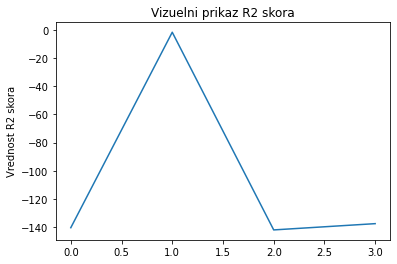

In [27]:
plt.title('Vizuelni prikaz R2 skora')
plt.ylabel('Vrednost R2 skora')
plt.plot([svr_rbf_score, svr_poly_score, svr_sigmoid_score, svr_linear_score])
plt.show()

### Vizuelni prikaz MSE

MSE:
 842520.0616504315 15492.555869386568 869601.2121116553 860051.4669584114


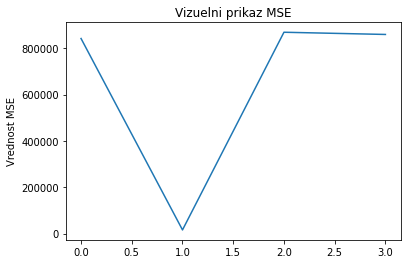

In [28]:
print('MSE:\n', mean_squared_error(y_test, svr_linear_pred), mean_squared_error(y_test, svr_poly_pred), mean_squared_error(y_test, svr_sigmoid_pred), mean_squared_error(y_test, svr_rbf_pred))

plt.title('Vizuelni prikaz MSE')
plt.ylabel('Vrednost MSE')
plt.plot([mean_squared_error(y_test, svr_linear_pred), mean_squared_error(y_test, svr_poly_pred), mean_squared_error(y_test, svr_sigmoid_pred), mean_squared_error(y_test, svr_rbf_pred)])
plt.show()

### Vizuelni prikaz MAE

MAE:
 914.54350637936 103.66145851231289 929.2698065659783 924.1076387053442


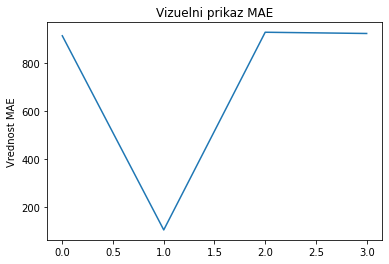

In [29]:
print('MAE:\n', mean_absolute_error(y_test, svr_linear_pred), mean_absolute_error(y_test, svr_poly_pred), mean_absolute_error(y_test, svr_sigmoid_pred), mean_absolute_error(y_test, svr_rbf_pred))

plt.title('Vizuelni prikaz MAE')
plt.ylabel('Vrednost MAE')
plt.plot([mean_absolute_error(y_test, svr_linear_pred), mean_absolute_error(y_test, svr_poly_pred), mean_absolute_error(y_test, svr_sigmoid_pred), mean_absolute_error(y_test, svr_rbf_pred)])
plt.show()

In [30]:
data.tail()

,Close,Predictions
4857372,58686.00,NaN
4857373,58685.81,NaN
4857374,58723.84,NaN
4857375,58760.59,NaN
4857376,58778.18,NaN


### Predvidjanje vrednosti za skup od poslednjih n instanci skupa podataka za koje je 'Predictions' = NaN

In [31]:
# data['Predictions'] = data[['Close']].shift(-n)
# data

In [32]:
# Kreiranje niza koji sadrzi poslednjih DAYS_TO_PREDICT_SVR dana
# (redova/instanci) iz originalnog skupa podataka

predictions_array = np.array(data.drop(['Predictions'],1))[-DAYS_TO_PREDICT_SVR:]
# print(predictions_array)

In [33]:
# Ispis stvarne vrednosti bitkoina u poslednjih n = 60 dana
# Predvidjene vrednosti su NaN

# print(data.tail(DAYS_TO_PREDICT_SVR))

In [34]:
# Predvidjanje i ispis predvidjenih vrednosti
# bitkoina u poslednjih DAYS_TO_PREDICT_SVR dana

svm_n_last_day_predictions = svr_rbf.predict(predictions_array)
# print(svm_n_last_day_predictions)

In [35]:
# Kreiranje DataFrame-a 'predictions_df' i
# dodavanje predvidjenih vrednosti u 'predictions_df'

predictions_df = pd.DataFrame(data['Close'][-DAYS_TO_PREDICT_SVR:], columns = ['Close'])
predictions_df['Predictions'] = svm_n_last_day_predictions
predictions_df.head()

,Close,Predictions
4857315,58711.15,57787.068458
4857316,58657.09,57787.068458
4857317,58651.95,57787.068458
4857318,58665.72,57787.068458
4857319,58599.47,57787.068458


In [36]:
# Uklanjanje NaN vrednosti (nastale usled siftovanja)
# iz originalnog DataFrame-a

data = data.dropna()
data.head()

,Close,Predictions
4854496,55804.36,55457.06
4854497,55857.28,55439.84
4854498,55779.04,55415.07
4854500,55768.63,55414.25
4854501,55742.20,55386.82


In [37]:
# Nadovezivanje kreiranog DataFrame-a na originalni DataFrame
# (dodavanje predvidjenih vrednosti u originalni DataFrame)

data = data.append(predictions_df)
data.head()

,Close,Predictions
4854496,55804.36,55457.06
4854497,55857.28,55439.84
4854498,55779.04,55415.07
4854500,55768.63,55414.25
4854501,55742.20,55386.82


In [38]:
# Provera

# data.tail(DAYS_TO_PREDICT_SVR)

In [44]:
# Cuvanje modela

filename_1 = 'svr_rbf.sav'
pickle.dump(svr_rbf, open(filename_1, 'wb'))

filename_2 = 'svr_poly.sav'
pickle.dump(svr_poly, open(filename_2, 'wb'))

filename_3 = 'svr_sigmoid.sav'
pickle.dump(svr_sigmoid, open(filename_3, 'wb'))

filename_4 = 'svr_linear.sav'
pickle.dump(svr_linear, open(filename_4, 'wb'))

Zakljucak

Koeficijent determinacije je negativna vrednost, sto nije pozeljno. Metrike kao sto su loss, MAE, MSE imaju velike vrednosti, sto takodje nije pozeljno.